# Data prep

In preparation for evalution, we first need to extract LUAD labels (0 or 1) and Leiden clusters for the **test subsample** of each of our models (note: the code cells perform the extraction for all test/train/val subsamples, but we only really need the test set). These arrays should correspond to the `image_filenames.npy` arrays generated in `extract_embeddings_hpl.ipynb`. There is also a code cell to combine all numpy arrays across test/train/val subsamples per model, but this will not be further used in this particular notebook.

**Output:** Numpy arrays of LUAD labels (`image_luad.npy`) and corresponding Leiden clusters (`image_leiden.npy`) in `test`, `train`, `val`, and `combined` subfolders. Make sure to adjust filepaths to your specific directory setup as you go through this notebook.

## Extracting LUAD labels

In [16]:
# load h5 file with luad 0/1 labels

import numpy as np
import pandas as pd
import h5py
import os

file_path = "/gpfs/home/yb2612/dl4med_25/dl_project/data/scratch_data/hdf5_TCGAFFPE_LUADLUSC_5x_60pc_he_complete_lungsubtype_survival_filtered.h5"

with h5py.File(file_path, 'r') as f:
    # list keys
    keys = list(f.keys())
    
    # exclude 'img_h_latent' and 'img_z_latent'
    exclude_keys = ['img_h_latent', 'img_z_latent']
    selected_keys = [key for key in keys if key not in exclude_keys]
    
    # make df
    data = {key: f[key][:] for key in selected_keys}
    lung_h5 = pd.DataFrame(data)
    
    # remove byte string 'b'
    lung_h5 = lung_h5.applymap(lambda x: x.decode() if isinstance(x, bytes) else x)

lung_h5['filepath'] = lung_h5.apply(
        lambda row: f"/gpfs/home/yb2612/dl4med_25/dl_project/data/scratch_data/{row['original_set']}/{row['slides']}/{row['tiles']}",
        axis=1
    )

# replace 'valid' with 'val' in filepath
lung_h5['filepath'] = lung_h5['filepath'].str.replace('valid', 'val')

lung_h5

/tmp/ipykernel_769339/1435766133.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lung_h5 = lung_h5.applymap(lambda x: x.decode() if isinstance(x, bytes) else x)


,indexes,labels,luad,original_set,os_event_data,os_event_ind,patterns,samples,slides,tiles,filepath
0,0,0.0,1,train,1.249315,1.0,TCGA-LUAD_not_reported,TCGA-73-4677,TCGA-73-4677-01Z-00-DX1,41_27.jpeg,/gpfs/home/yb2612/dl4med_25/dl_project/data/sc...
1,1,0.0,1,train,71.473973,1.0,TCGA-LUAD_not_reported,TCGA-50-5045,TCGA-50-5045-01Z-00-DX1,18_22.jpeg,/gpfs/home/yb2612/dl4med_25/dl_project/data/sc...
2,2,0.0,1,train,5.424658,0.0,TCGA-LUAD_not_reported,TCGA-69-7765,TCGA-69-7765-01Z-00-DX1,33_15.jpeg,/gpfs/home/yb2612/dl4med_25/dl_project/data/sc...
3,3,0.0,1,train,5.424658,0.0,TCGA-LUAD_not_reported,TCGA-69-7765,TCGA-69-7765-01Z-00-DX1,34_13.jpeg,/gpfs/home/yb2612/dl4med_25/dl_project/data/sc...
4,4,0.0,1,train,1.249315,1.0,TCGA-LUAD_not_reported,TCGA-73-4677,TCGA-73-4677-01Z-00-DX1,23_14.jpeg,/gpfs/home/yb2612/dl4med_25/dl_project/data/sc...
...,...,...,...,...,...,...,...,...,...,...,...
840974,148732,9.0,0,test,36.065753,1.0,TCGA-LUSC_stage_iv,TCGA-18-3417,TCGA-18-3417-01Z-00-DX1,30_25.jpeg,/gpfs/home/yb2612/dl4med_25/dl_project/data/sc...
840975,148733,9.0,0,test,36.065753,1.0,TCGA-LUSC_stage_iv,TCGA-18-3417,TCGA-18-3417-01Z-00-DX1,26_29.jpeg,/gpfs/home/yb2612/dl4med_25/dl_project/data/sc...
840976,148734,9.0,0,test,36.065753,1.0,TCGA-LUSC_stage_iv,TCGA-18-3417,TCGA-18-3417-01Z-00-DX1,4_8.jpeg,/gpfs/home/yb2612/dl4med_25/dl_project/data/sc...
840977,148735,9.0,0,test,36.065753,1.0,TCGA-LUSC_stage_iv,TCGA-18-3417,TCGA-18-3417-01Z-00-DX1,27_22.jpeg,/gpfs/home/yb2612/dl4med_25/dl_project/data/sc...


In [23]:
# create dict for fast matching
filepath_to_luad = {}
for index, row in lung_h5.iterrows():
    filepath_to_luad[row['filepath']] = row['luad']

In [24]:
model_names = ["hpl", "clip-scratch", "conch"]
splits = ["test", "train", "val"]

for model_name in model_names:
    for split in splits:
        try:
            print(f"Extracting labels for {model_name}/{split}...")
            filenames = np.load(f"/gpfs/home/yb2612/dl4med_25/dl_project/results/{model_name}/{split}/image_filenames.npy", allow_pickle=True)
            print(f"Loaded {len(filenames)} filenames")
            
            # extract luad based on filepath
            labels = []
            found_count = 0
            
            for filepath in filenames:
                
                if filepath in filepath_to_luad:
                    # exact match found
                    label = filepath_to_luad[filepath]
                    labels.append(label)
                    found_count += 1
                else:
                    # in case exact match fails
                    matched = False
                    for df_path in filepath_to_luad.keys():
                        if os.path.basename(filepath) == os.path.basename(df_path):
                            label = filepath_to_luad[df_path]
                            labels.append(label)
                            found_count += 1
                            matched = True
                            break
                    
                    if not matched:
                        # -1 if not found
                        labels.append(-1)
            
            labels = np.array(labels)
            
            print(f"Found labels for {found_count} out of {len(labels)} files")

            # save
            os.makedirs(f"/gpfs/home/yb2612/dl4med_25/dl_project/results/{model_name}/{split}", exist_ok=True)
            output_path = f"/gpfs/home/yb2612/dl4med_25/dl_project/results/{model_name}/{split}/image_luad.npy"
            np.save(output_path, labels)
            print(f"Saved labels to {output_path}")
            
        except Exception as e:
            print(f"Error processing {model_name}/{split}: {e}")

Extracting labels for hpl/test...
Loaded 27734 filenames
Found labels for 27734 out of 27734 files
Saved labels to /gpfs/home/yb2612/dl4med_25/dl_project/results/hpl/test/image_luad.npy
Extracting labels for hpl/train...
Loaded 126693 filenames
Found labels for 126693 out of 126693 files
Saved labels to /gpfs/home/yb2612/dl4med_25/dl_project/results/hpl/train/image_luad.npy
Extracting labels for hpl/val...
Loaded 32236 filenames
Found labels for 32236 out of 32236 files
Saved labels to /gpfs/home/yb2612/dl4med_25/dl_project/results/hpl/val/image_luad.npy
Extracting labels for clip-scratch/test...
Loaded 27734 filenames
Found labels for 27734 out of 27734 files
Saved labels to /gpfs/home/yb2612/dl4med_25/dl_project/results/clip-scratch/test/image_luad.npy
Extracting labels for clip-scratch/train...
Loaded 126693 filenames
Found labels for 126693 out of 126693 files
Saved labels to /gpfs/home/yb2612/dl4med_25/dl_project/results/clip-scratch/train/image_luad.npy
Extracting labels for clip

## Extracting Leiden clusters

In [25]:
import numpy as np
import pandas as pd
import os

model_names = ["hpl", "clip-scratch", "conch"]
splits = ["test", "train", "val"]

for model_name in model_names:
    for split in splits:
        print(f"\nProcessing {model_name}/{split}...")
        
        try:
            # path to filename array
            filenames_path = f"/gpfs/home/yb2612/dl4med_25/dl_project/results/{model_name}/{split}/image_filenames.npy"

            # path to leiden cluster csv
            leiden_path = f"/gpfs/home/yb2612/dl4med_25/dl_project/results/{model_name}/{split}/umap_leiden_results.csv"

            filenames = np.load(filenames_path, allow_pickle=True)
            print(f"Loaded {len(filenames)} filenames")
            
            leiden_df = pd.read_csv(leiden_path)
            print(f"Loaded {len(leiden_df)} leiden cluster assignments")
            
            # create dict for fast matching
            filepath_to_leiden = {}
            for index, row in leiden_df.iterrows():
                filepath_to_leiden[row['filepath']] = row['leiden_2.0']
            
            # extract clusters
            leiden_clusters = []
            found_count = 0
            
            for filepath in filenames:
                # exact match
                if filepath in filepath_to_leiden:
                    cluster = filepath_to_leiden[filepath]
                    leiden_clusters.append(cluster)
                    found_count += 1
                else:
                    # basename match
                    matched = False
                    basename = os.path.basename(filepath)
                    
                    for df_path in filepath_to_leiden.keys():
                        if basename == os.path.basename(df_path):
                            cluster = filepath_to_leiden[df_path]
                            leiden_clusters.append(cluster)
                            found_count += 1
                            matched = True
                            break
                    
                    if not matched:
                        # -1 for not found
                        leiden_clusters.append(-1)
            
            leiden_clusters = np.array(leiden_clusters)
            
            # count matches
            print(f"Found clusters for {found_count} out of {len(leiden_clusters)} files")
            
            # save leiden clusters
            output_path = f"/gpfs/home/yb2612/dl4med_25/dl_project/results/{model_name}/{split}/image_leiden.npy"
            np.save(output_path, leiden_clusters)
            print(f"Saved leiden clusters to {output_path}")
            
        except FileNotFoundError as e:
            print(f"File not found: {e}")
        except Exception as e:
            print(f"Error: {e}")


Processing hpl/test...
Loaded 27734 filenames
Loaded 27734 leiden cluster assignments
Found clusters for 27734 out of 27734 files
Saved leiden clusters to /gpfs/home/yb2612/dl4med_25/dl_project/results/hpl/test/image_leiden.npy

Processing hpl/train...
Loaded 126693 filenames
Loaded 126769 leiden cluster assignments
Found clusters for 126693 out of 126693 files
Saved leiden clusters to /gpfs/home/yb2612/dl4med_25/dl_project/results/hpl/train/image_leiden.npy

Processing hpl/val...
Loaded 32236 filenames
Loaded 32236 leiden cluster assignments
Found clusters for 32236 out of 32236 files
Saved leiden clusters to /gpfs/home/yb2612/dl4med_25/dl_project/results/hpl/val/image_leiden.npy

Processing clip-scratch/test...
Loaded 27734 filenames
Loaded 27734 leiden cluster assignments
Found clusters for 27734 out of 27734 files
Saved leiden clusters to /gpfs/home/yb2612/dl4med_25/dl_project/results/clip-scratch/test/image_leiden.npy

Processing clip-scratch/train...
Loaded 126693 filenames
Load

## Combining train/val/test arrays

In [29]:
import numpy as np
import os
import glob

# Define models
models = ["hpl", "clip-scratch", "conch"]
splits = ["train", "val", "test"]
base_path = "/gpfs/home/yb2612/dl4med_25/dl_project/results"

for model_name in models:
    print(f"\nProcessing {model_name}...")
    
    all_embeddings = []
    all_filenames = []
    all_luad_labels = []
    
    # dict to track samples per split
    split_counts = {}
    
    # for each split...
    for split in splits:
        try:
            # construct paths
            embeddings_path = os.path.join(base_path, model_name, split, "image_embeddings.npy")
            filenames_path = os.path.join(base_path, model_name, split, "image_filenames.npy")
            luad_path = os.path.join(base_path, model_name, split, "image_luad.npy")
            
            # load data
            embeddings = np.load(embeddings_path, allow_pickle=True)
            filenames = np.load(filenames_path, allow_pickle=True)
            luad_labels = np.load(luad_path, allow_pickle=True)
            
            # make sure data has same length
            if len(embeddings) == len(filenames) == len(luad_labels):
                print(f"  Loaded {split}: {len(embeddings)} samples, embedding shape: {embeddings.shape}")
                
                # filter missing labels (-1)
                valid_indices = luad_labels != -1
                if not np.all(valid_indices):
                    print(f"  Filtering out {np.sum(~valid_indices)} samples with missing labels in {split}")
                    embeddings = embeddings[valid_indices]
                    filenames = filenames[valid_indices]
                    luad_labels = luad_labels[valid_indices]
                
                # store count for split
                split_counts[split] = len(embeddings)
                
                # append to lists
                all_embeddings.append(embeddings)
                all_filenames.append(filenames)
                all_luad_labels.append(luad_labels)
            else:
                print(f"  Error: Mismatched data lengths in {split} for {model_name}")
                print(f"    embeddings: {len(embeddings)}, filenames: {len(filenames)}, luad: {len(luad_labels)}")
            
        except Exception as e:
            print(f"  Error loading {split} data for {model_name}: {e}")
    
    # combine everything
    if all_embeddings:
        combined_embeddings = np.vstack(all_embeddings)
        combined_filenames = np.concatenate(all_filenames)
        combined_luad = np.concatenate(all_luad_labels)
        
        print(f"  Combined data: {len(combined_embeddings)} samples, embedding shape: {combined_embeddings.shape}")
        print(f"  LUAD distribution: LUAD={np.sum(combined_luad==1)}, LUSC={np.sum(combined_luad==0)}")
        
        # save
        combined_dir = os.path.join(base_path, model_name, "combined")
        os.makedirs(combined_dir, exist_ok=True)
        
        combined_embeddings_path = os.path.join(combined_dir, "image_embeddings.npy")
        combined_filenames_path = os.path.join(combined_dir, "image_filenames.npy") 
        combined_luad_path = os.path.join(combined_dir, "image_luad.npy")
        
        np.save(combined_embeddings_path, combined_embeddings)
        np.save(combined_filenames_path, combined_filenames)
        np.save(combined_luad_path, combined_luad)
        
        # save split info as text file
        split_info = {
            "total_samples": len(combined_embeddings),
            "luad_count": int(np.sum(combined_luad==1)),
            "lusc_count": int(np.sum(combined_luad==0)),
            "splits": split_counts
        }
        
        with open(os.path.join(combined_dir, "split_info.txt"), "w") as f:
            f.write(f"Total samples: {split_info['total_samples']}\n")
            f.write(f"LUAD: {split_info['luad_count']}, LUSC: {split_info['lusc_count']}\n")
            f.write("Samples per split:\n")
            for split, count in split_info['splits'].items():
                f.write(f"  {split}: {count}\n")
        
        print(f"  Saved combined data to {combined_dir}/")
        print(f"  Split counts: {split_counts}")
    else:
        print(f"  No data found for {model_name}")

print("\nCombination complete!")


Processing hpl...
  Loaded train: 126693 samples, embedding shape: (126693, 128)
  Loaded val: 32236 samples, embedding shape: (32236, 128)
  Loaded test: 27734 samples, embedding shape: (27734, 128)
  Combined data: 186663 samples, embedding shape: (186663, 128)
  LUAD distribution: LUAD=93123, LUSC=93540
  Saved combined data to /gpfs/home/yb2612/dl4med_25/dl_project/results/hpl/combined/
  Split counts: {'train': 126693, 'val': 32236, 'test': 27734}

Processing clip-scratch...
  Loaded train: 126693 samples, embedding shape: (126693, 1024)
  Loaded val: 32236 samples, embedding shape: (32236, 1024)
  Loaded test: 27734 samples, embedding shape: (27734, 1024)
  Combined data: 186663 samples, embedding shape: (186663, 1024)
  LUAD distribution: LUAD=93123, LUSC=93540
  Saved combined data to /gpfs/home/yb2612/dl4med_25/dl_project/results/clip-scratch/combined/
  Split counts: {'train': 126693, 'val': 32236, 'test': 27734}

Processing conch...
  Loaded train: 126693 samples, embedding

# Cluster assignment similarity

**Do the Leiden clusters identified by our HPL-Modified models agree with clusters from the original HPL pipeline?** We can use the adjusted Rand index (ARI) to evaluate cluster similarity.

In [5]:
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score

def compute_and_plot_ari(base_dir, model_name_map, ground_truth_model='hpl'):
    """
    Compute Adjusted Rand Index (ARI) between ground truth model and a list of models, and plot a bar chart.

    Args:
        base_dir (str): Base directory where results are stored.
        model_name_map (dict): Dictionary mapping folder names to custom display names.
        ground_truth_model (str): Folder name for ground truth clustering (default 'hpl').

    Returns:
        dict: Dictionary mapping display names to their ARI scores.
    """
    # ground truth labels
    hpl_labels_path = os.path.join(base_dir, ground_truth_model, 'test', 'image_leiden.npy')
    hpl_labels = np.load(hpl_labels_path)

    # number of clusters for ground truth
    print(f"Number of clusters ({ground_truth_model.upper()}): {len(np.unique(hpl_labels))}")

    ari_scores = {}
    num_clusters = {}

    for folder_name, display_name in model_name_map.items():
        model_labels_path = os.path.join(base_dir, folder_name, 'test', 'image_leiden.npy')
        model_labels = np.load(model_labels_path)

        # number of clusters for comparison model
        print(f"Number of clusters ({display_name}): {len(np.unique(model_labels))}")

        # make sure dimensions of both arrays are the same
        assert hpl_labels.shape == model_labels.shape, f"Shape mismatch between {ground_truth_model} and {folder_name}"

        # calculate ARI
        ari = adjusted_rand_score(hpl_labels, model_labels)
        ari_scores[display_name] = ari
        num_clusters[display_name] = len(np.unique(model_labels))
        print(f"Adjusted Rand Index ({display_name} vs {ground_truth_model.upper()}): {ari:.4f}")

    # bar plot for ARI
    plt.figure(figsize=(6, 4))
    methods = [f"{ground_truth_model.upper()}-{name}" for name in ari_scores.keys()]
    ari_values = list(ari_scores.values())

    bars = plt.bar(methods, ari_values, color='black')
    plt.ylim(0, 1)
    plt.ylabel('Adjusted Rand Index')
    plt.title('Clustering agreement with HPL')
    plt.grid(axis='y', linestyle='', alpha=0.7)

    # show value above bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.02, f'{height:.2f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig("/gpfs/home/yb2612/dl4med_25/dl_project/results/evaluation/cluster_similarity.png")
    plt.show()

    return ari_scores

Number of clusters (HPL): 38
Number of clusters (CLIP): 25
Adjusted Rand Index (CLIP vs HPL): 0.0628
Number of clusters (CONCH): 32
Adjusted Rand Index (CONCH vs HPL): 0.1746


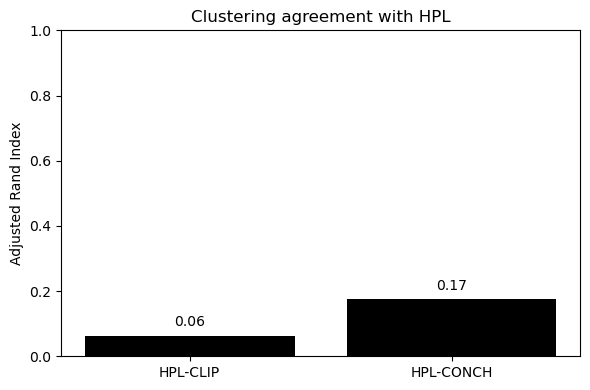

In [6]:
base_dir = '/gpfs/home/yb2612/dl4med_25/dl_project/results'

model_name_map = {
    'clip-scratch': 'CLIP',
    'conch': 'CONCH',
    # 'vicreg': 'VICReg',
    # 'vit': 'ViT'
}

ari_scores = compute_and_plot_ari(base_dir, model_name_map)

Let's also check the number of clusters identified per model.

In [7]:
def plot_num_clusters(base_dir, model_name_map):
    """
    Plot number of clusters for a list of models.

    Args:
        base_dir (str): Base directory where results are stored.
        model_name_map (dict): Dictionary mapping folder names to custom display names.
    """
    cluster_counts = {}

    # models
    for folder_name, display_name in model_name_map.items():
        model_labels_path = os.path.join(base_dir, folder_name, 'test', 'image_leiden.npy')
        model_labels = np.load(model_labels_path)
        cluster_counts[display_name] = len(np.unique(model_labels))

    # bar plot
    plt.figure(figsize=(6, 4))
    names = list(cluster_counts.keys())
    counts = list(cluster_counts.values())

    bars = plt.bar(names, counts, color='black')
    plt.ylabel('Number of clusters')
    plt.title('Number of clusters per model')
    plt.grid(axis='y', linestyle='', alpha=0.7)

    # show value above bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, f'{int(height)}', ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig("/gpfs/home/yb2612/dl4med_25/dl_project/results/evaluation/number_of_clusters.png")
    plt.show()

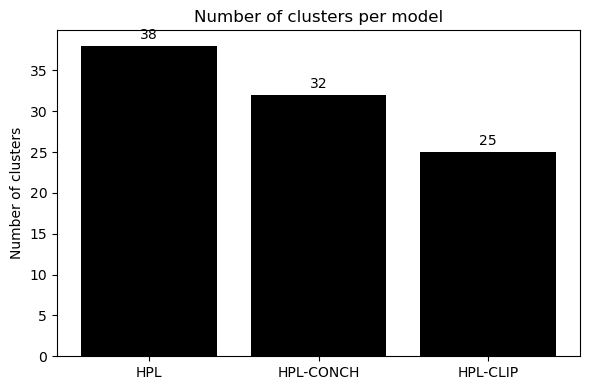

In [8]:
base_dir = '/gpfs/home/yb2612/dl4med_25/dl_project/results'

model_name_map = {
    'hpl': 'HPL',
    'conch': 'HPL-CONCH',
    'clip-scratch': 'HPL-CLIP',
    # 'vicreg': 'VICReg',
    # 'vit': 'ViT'
}

# number of clusters
plot_num_clusters(base_dir, model_name_map)

# Partitioning of LUAD vs. LUSC by cluster

Recall that the point of HPL is to define pathologically relevant clusters. One major pathological feature is lung cancer subtype: lung adenocarcinoma (LUAD) or lung squamous cell carcinoma (LUSC). Now we ask: **How well do clusters from each model separate LUAD from LUSC?** 

First we evaluate cluster homogeneity with respect to LUAD/LUSC labels. This metric ranges from 0 to 1, where 0 indicates that all clusters contain highly mixed LUAD/LUSC cases, and 1 indicates that each cluster contains only one class.

In [27]:
import numpy as np
from sklearn.metrics import homogeneity_score
import os
import matplotlib.pyplot as plt

def evaluate_homogeneity(model_label_paths, luad_labels_path, model_names):
    """
    model_label_paths: list of paths to model clustering label .npy files
    luad_labels_path: path to ground truth luad/lusc label .npy file
    model_names: custom names for the models
    """
    luad_labels = np.load(luad_labels_path)
    
    homogeneity_scores = []
    
    for path in model_label_paths:
        model_labels = np.load(path)
        assert model_labels.shape == luad_labels.shape, f"Shape mismatch between {path} and LUAD labels."
        
        # calculate homogeneity
        homogeneity = homogeneity_score(luad_labels, model_labels)
        
        # append scores to list
        homogeneity_scores.append(homogeneity)
    
    # bar plot
    x = np.arange(len(model_names))
    
    fig, ax = plt.subplots(figsize=(6, 4))
    
    bars = ax.bar(x, homogeneity_scores, label='Homogeneity', color='black')
    
    ax.set_ylabel('Homogeneity score')
    ax.set_title('Cluster homogeneity relative to LUAD/LUSC')
    ax.set_xticks(x)
    ax.set_xticklabels(model_names)
    ax.set_ylim(0, 1)
    ax.grid(axis='y', linestyle='', alpha=0.7)
    
    # show value above bar
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.savefig("/gpfs/home/yb2612/dl4med_25/dl_project/results/evaluation/cluster_homogeneity.png")
    plt.show()
    
    return homogeneity_scores

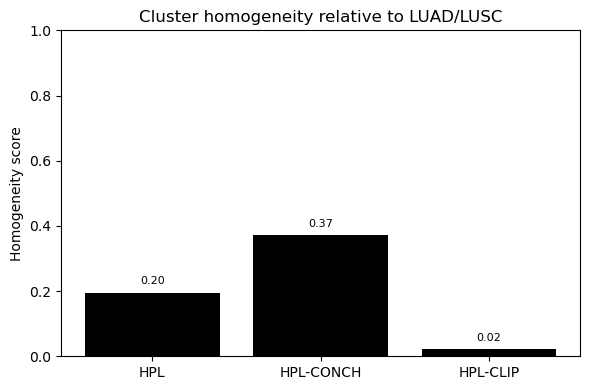

In [28]:
base_dir = '/gpfs/home/yb2612/dl4med_25/dl_project/results'

# paths to leiden cluster arrays
model_label_paths = [
    os.path.join(base_dir, 'hpl', 'test', 'image_leiden.npy'),
    os.path.join(base_dir, 'conch', 'test', 'image_leiden.npy'),
    os.path.join(base_dir, 'clip-scratch', 'test', 'image_leiden.npy'),
]

# path to LUAD 0/1 label array (should be the same for all models)
luad_labels_path = os.path.join(base_dir, 'hpl', 'test', 'image_luad.npy')

# model names
model_names = ['HPL', 'HPL-CONCH', 'HPL-CLIP']

# calculate and plot all metrics
homogeneity_scores = evaluate_homogeneity(model_label_paths, luad_labels_path, model_names)

Next we treat clusters as pseudo-classifiers - that is, if a cluster is mostly LUAD, we “predict” all tiles in that cluster to be LUAD. Then we calculate accuracy and F1 scores using predicted and ground truth labels.

In [11]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_models(model_label_paths, luad_labels_path, model_names):
    """
    model_label_paths: list of paths to model clustering label .npy files
    luad_labels_path: path to ground truth luad/lusc label .npy file
    model_names: custom names for the models
    """
    # load the luad/lusc ground truth labels
    luad_labels = np.load(luad_labels_path)
    
    # initialize lists to store evaluation metrics
    accuracy_scores = []
    f1_scores = []
    
    for path in model_label_paths:
        model_labels = np.load(path)
        
        # ensure the shapes match
        assert model_labels.shape == luad_labels.shape, f"Shape mismatch between {path} and luad labels."
        
        # map clusters to classes by majority voting
        cluster_to_class = {}
        for cluster_id in np.unique(model_labels):
            cluster_mask = model_labels == cluster_id
            majority_class = np.bincount(luad_labels[cluster_mask]).argmax()
            cluster_to_class[cluster_id] = majority_class
        
        # apply mapping
        model_labels_mapped = np.array([cluster_to_class[label] for label in model_labels])
        
        # calculate classification metrics
        accuracy = accuracy_score(luad_labels, model_labels_mapped)
        f1 = f1_score(luad_labels, model_labels_mapped)
        
        # store
        accuracy_scores.append(accuracy)
        f1_scores.append(f1)
    
    # plotting
    x = np.arange(len(model_names))
    width = 0.3
    
    fig, ax = plt.subplots(figsize=(8, 5))
    
    colors = sns.color_palette("Set2", 2)
    
    bars1 = ax.bar(x - width/2, accuracy_scores, width, label='Accuracy', color=colors[0])
    bars2 = ax.bar(x + width/2, f1_scores, width, label='F1 Score', color=colors[1])
    
    ax.set_ylabel('Score')
    ax.set_title('Cluster performance in classifying LUAD and LUSC')
    ax.set_xticks(x)
    ax.set_xticklabels(model_names)
    ax.legend()
    ax.set_ylim(0, 1.05)
    ax.grid(axis='y', linestyle='', alpha=0.7)
    
    # show value above bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f'{height:.2f}', ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.savefig("/gpfs/home/yb2612/dl4med_25/dl_project/results/evaluation/luad_lusc_classification.png")
    plt.show()
    
    return accuracy_scores, f1_scores

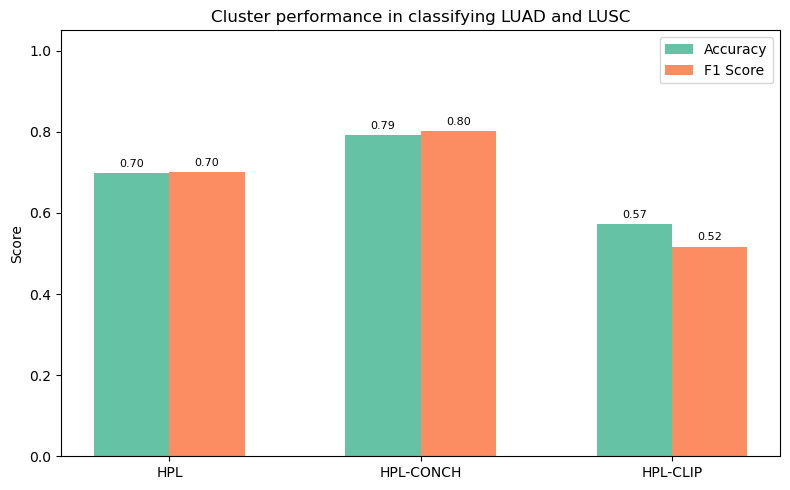

In [12]:
base_dir = '/gpfs/home/yb2612/dl4med_25/dl_project/results'

# leiden cluster arrays per model
model_label_paths = [
    os.path.join(base_dir, 'hpl', 'test', 'image_leiden.npy'),
    os.path.join(base_dir, 'conch', 'test', 'image_leiden.npy'),
    os.path.join(base_dir, 'clip-scratch', 'test', 'image_leiden.npy'),
]

# LUAD labels array
luad_labels_path = os.path.join(base_dir, 'hpl', 'test', 'image_luad.npy')

# model names
model_names = ['HPL', 'HPL-CONCH', 'HPL-CLIP']

# classification metrics
accuracy_scores, f1_scores = evaluate_models(model_label_paths, luad_labels_path, model_names)